In [1]:
import gym
import tensorflow as tf
import numpy as np

In [2]:
env = gym.make('CartPole-v1')
print(env.observation_space.sample())
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
print(n_actions)
print(n_states)

[2017-11-09 12:47:26,642] Making new env: CartPole-v1


[  4.68609638e-01   1.46450285e+38   8.60908446e-02   3.05459097e+37]
2
4


In [3]:
n_hidden = 32
learning_rate = 0.02
gamma = 0.99
episodes = 500
t_max = 1000
np.random.seed(1)
tf.set_random_seed(1)

In [4]:
states = tf.placeholder(tf.float32, shape=[None, n_states], name='states')
actions = tf.placeholder(tf.int32, name='actions')
rewards = tf.placeholder(tf.float32, name='rewards')

In [5]:
w_hid1 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_states, n_hidden]), name='whid1')
w_bias1 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_hidden]), name='wbias1')
out1 = tf.add(tf.matmul(states, w_hid1),w_bias1)
w_hid2 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_hidden, n_actions]), name='whid2')
w_bias2 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_actions]), name='wbias2')
out = tf.add(tf.matmul(out1, w_hid2), w_bias2)

logits = tf.nn.softmax(out)

In [6]:
neg_log_prob = -tf.reduce_sum(tf.log(logits)*tf.one_hot(actions, n_actions), axis=1)
loss = tf.reduce_mean(neg_log_prob * rewards)

update = tf.train.AdamOptimizer(learning_rate).minimize(loss) 

In [15]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    discounted_ep_rs = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted_ep_rs[t] = running_add

        # normalize episode rewards
    discounted_ep_rs -= np.mean(discounted_ep_rs)
    discounted_ep_rs /= np.std(discounted_ep_rs)
    return discounted_ep_rs
    
test_rew = [1.0, 2.0, 3.0, 4.0, 5.0, -1.0] 
print(get_cumulative_rewards(test_rew, 0.1))

[-0.6612174  -0.11133761  0.43541745  0.95092512  1.15395888 -1.76774644]


In [7]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    final = []
    for i in range(len(rewards)):
        temp = rewards[i]
        for j in range(i+1, len(rewards)):
            temp = temp + rewards[j] * (gamma ** (j - i))
        final.append(temp)
    final -= np.mean(final)
    final /= np.std(final)
    return final
    
test_rew = [1.0, 2.0, 3.0] 
print(get_cumulative_rewards(test_rew, 0.1))

[-1.30064665  0.16945044  1.1311962 ]


In [8]:
def choose_action(state):
    prob_weights = logits.eval(feed_dict={states: state})[0]
    action = np.random.choice(range(n_actions), p=prob_weights.ravel())  # select action w.r.t the actions prob
    return action

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

reward_list = []

for i in range(episodes):
    s = env.reset()
    s_, a_, r_ = [], [], []
    for t in range(t_max):
        s = np.reshape(s, (-1, 4))
        a = choose_action(s)
        new_s, r, done, _ = env.step(a)
        s_.append(s)
        a_.append(a)
        r_.append(r)
        s = new_s
        if done:
            r_cumu = get_cumulative_rewards(r_)
            s_new = np.reshape(s_, (-1, n_states))
            update.run({states:s_new, actions:a_, rewards:r_cumu})
            print('episode:{0} reward:{1}'.format(i, sum(r_)))
            reward_list.append(sum(r_))
            break

episode:0 reward:91.0
episode:1 reward:76.0
episode:2 reward:107.0
episode:3 reward:75.0
episode:4 reward:106.0
episode:5 reward:81.0
episode:6 reward:42.0
episode:7 reward:39.0
episode:8 reward:31.0
episode:9 reward:30.0
episode:10 reward:25.0
episode:11 reward:19.0
episode:12 reward:30.0
episode:13 reward:26.0
episode:14 reward:32.0
episode:15 reward:40.0
episode:16 reward:39.0
episode:17 reward:45.0
episode:18 reward:51.0
episode:19 reward:48.0
episode:20 reward:62.0
episode:21 reward:66.0
episode:22 reward:98.0
episode:23 reward:87.0
episode:24 reward:70.0
episode:25 reward:90.0
episode:26 reward:73.0
episode:27 reward:49.0
episode:28 reward:95.0
episode:29 reward:94.0
episode:30 reward:67.0
episode:31 reward:92.0
episode:32 reward:92.0
episode:33 reward:65.0
episode:34 reward:51.0
episode:35 reward:113.0
episode:36 reward:143.0
episode:37 reward:94.0
episode:38 reward:125.0
episode:39 reward:84.0
episode:40 reward:167.0
episode:41 reward:208.0
episode:42 reward:136.0
episode:43 re

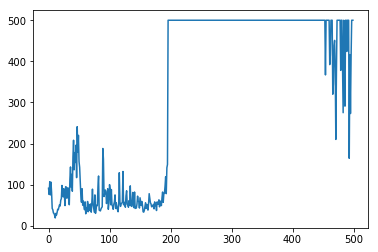

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_list)
plt.show()

In [16]:
s = env.reset()
r_test = 0
for t in range(t_max):
    env.render()
    s = np.reshape(s, (-1, 4))
    a = choose_action(s)
    new_s, r, done, _ = env.step(a)
    s = new_s
    r_test = r + r_test
    if done:
        break
print(r_test)

500.0
